# Условие

Обучить бинарный классификатор на основе сверточных нейронных сетей для датасета.
- Вы вольны выбирать любое количество слоёв, подбирать гиперпараметры, выбирать оптимизатор, функцию ошибки итд.    
- Можете разбивать на train-val-test исходя из того, как думаете, что будет лучше.

4 балла:
- Модель должна работоспособна, воспроизводима, код должен быть читаемым;
- Метрика качества accuracy должна быть не ниже 0.9;
- Процесс схождения должен быть залогирован (хотя бы просто графиками в matplotlib, но желательно втч. и в Tensorboard/ClearML/...).

5 баллов:
- Всё то же самое, что на 4 балла, но выполнены подзадания 1, 2 и 3, а метрика качества accuracy должна быть не ниже 0.95.



Подзадания:
- [X] Выведите кол-во обучаемых параметров сети;    
- [X] Напишите несколько предложений выводов - что помогло в решении и повысило качество, что нет.
- [X] Посчитайте F1-score на тестовой подвыборке.

По желанию к выполнению, в разбалловке не учитывается:     
- [ ] Выведите confusion matrix для тестовой подвыборки;    

# Особенности

У меня все выполнялось на cpu, разрешили взять половину

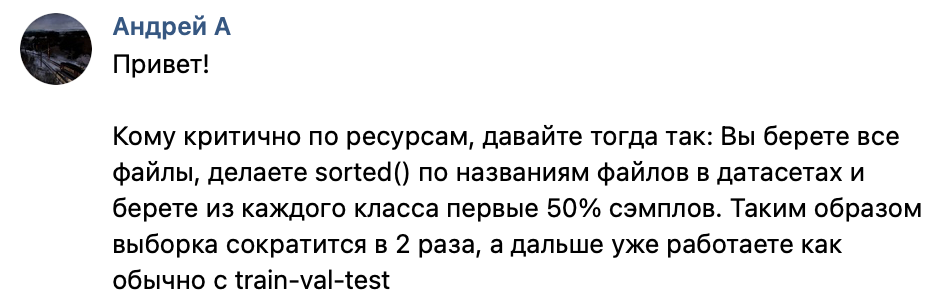


# Домашняя работа

## Подключаем билиотеки и константы

In [4]:
!pip install torchmetrics numpy torch matplotlib torchvision tqdm progressbar tensorboard

Defaulting to user installation because normal site-packages is not writeable
  Using cached absl_py-2.1.0-py3-none-any.whl.metadata (2.3 kB)
  Using cached tensorboard_data_server-0.7.2-py3-none-any.whl.metadata (1.1 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 1.4 MB/s eta 0:00:00a 0:00:010m
Using cached absl_py-2.1.0-py3-none-any.whl (133 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 2.1 MB/s eta 0:00:0000:0100:01
Using cached tensorboard_data_server-0.7.2-py3-none-any.whl (2.4 kB)


In [24]:
import os
import warnings
import time
import progressbar

import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

import torchvision
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision.utils import make_grid
import torchvision.transforms as transforms
from torch import no_grad, max, device, cuda
from torch.utils.tensorboard import SummaryWriter
from torchvision.datasets import ImageFolder
from torch.utils.data import TensorDataset, DataLoader, random_split
from torch.utils.tensorboard import SummaryWriter
from torchmetrics.classification import BinaryF1Score
from sklearn.metrics import f1_score   

warnings.filterwarnings('ignore')
%matplotlib inline

In [6]:
DEVICE = device("cuda:0" if cuda.is_available() else "cpu")
print(DEVICE)

cpu


## Подгрузка данных

In [32]:
SHAPE = 256
data_dir = './indoor_outdoor_dataset/'

transform = transforms.Compose([
    transforms.AugMix(),
    transforms.RandomRotation(degrees=(0, 180)),
    transforms.Resize([SHAPE, SHAPE]),
    transforms.ToTensor(),           
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

full_data = ImageFolder(data_dir, transform=transform)

train_size = int(0.9 * len(full_data))
test_size = len(full_data) - train_size
print(f'train_size = {train_size}\ntest_size = {test_size}')

train_data, test_data = random_split(full_data, [train_size, test_size])

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

train_size = 369471
test_size = 41053


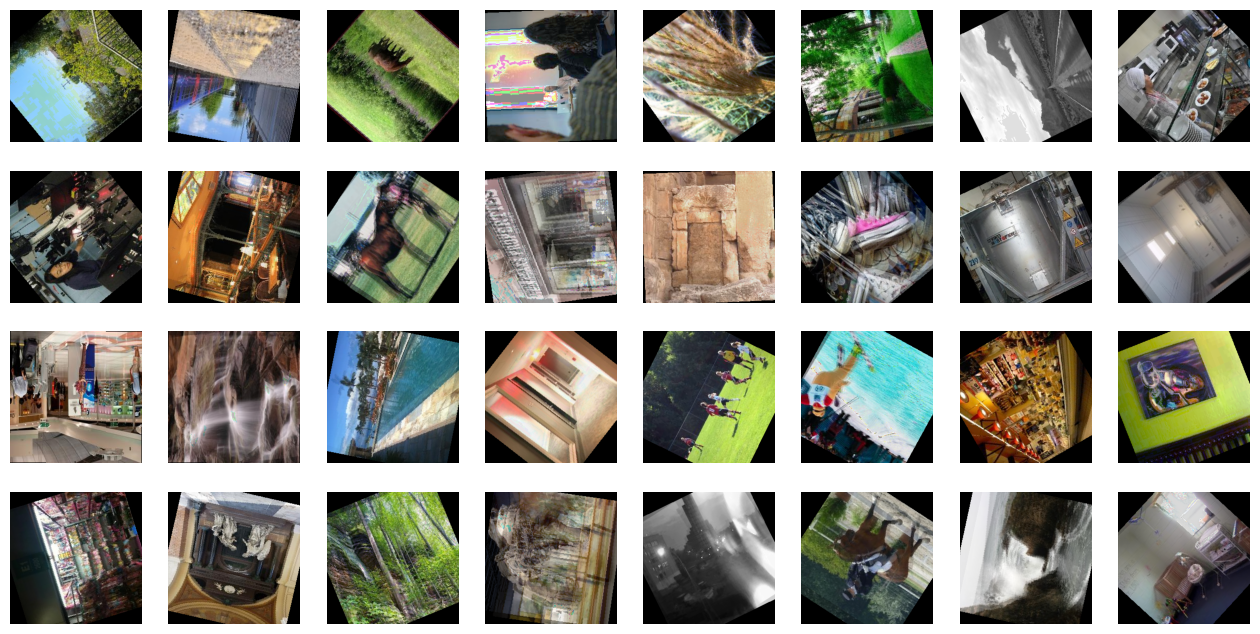

In [34]:
_image, cols = [], 4
buffer_images, _ = next(iter(train_loader))
_image = [ make_grid(buffer_image, normalize=True).permute(1, 2, 0).numpy() \
          for buffer_image in buffer_images]
plt.figure(figsize=(16, 8))
rows = int(len(_image)/cols)
for i, image in enumerate(_image, 1):
    plt.subplot(cols, rows, i)
    plt.imshow(image)
    plt.axis("off")
plt.show()

**Что-то сильный шум на вид, возможно надо будет перегнать**

In [14]:
LEARNING_RATE = 0.01
EPOCH = 40

## Класс Model

In [15]:
class Model:
    def __init__(self, model, criterion, optimizer):
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self._f1_score = BinaryF1Score()

    def plotLAF(
            self,
            train_loss_epochs, test_loss_epochs,
            train_accuracy_epochs, test_accuracy_epochs,
            train_f1_epochs, test_f1_epochs,
            epochs=EPOCH
        ):
    
        train = [ train_loss_epochs, train_accuracy_epochs, train_f1_epochs ]
        test = [ test_loss_epochs, test_accuracy_epochs, test_f1_epochs ]
        label = [ 'Loss', 'Accuracy', 'F1' ]
        plt.figure(figsize=(12.5, 4))
        for i in range(1, 4):
            plt.subplot(1, 3, i)
            plt.plot(train[(i - 1)], label='Train', linewidth=1.0)
            plt.plot(test[(i - 1)], label='Test', linewidth=1.0)
            plt.xlabel('Epochs')
            plt.ylabel(label[(i - 1)])
            plt.ylim([0, 1, 0.2, 0.4, 0.6, 0.8, 0.9, 0.95])
            plt.xlim([0, epochs])
            plt.legend(loc=0)
            plt.grid()
        plt.show()
    
    def _accuracy(self, outputs, labels):
        self._pred = (outputs > 0.5).float()
        return torch.sum(self._pred == labels).item() / len(labels)

    def _f1(self, labels):
        return self._f1_score(self._pred, labels)
    
    def train(self, train_loader, test_loader, epochs, accurate_break=0.951):
        train_loss_epochs, train_accuracy_epochs, train_f1_epochs = [], [], []
        test_loss_epochs, test_accuracy_epochs, test_f1_epochs = [], [], []

        for epoch in tqdm(range(epochs)):
            start_time = time.time()
            running_loss, running_acc, running_f1 = [], [], []
            test_loss, test_acc, test_f1 = [], [], []

            # Обучение
            self.model.train()
            for i, (inputs, labels) in enumerate(train_loader):
                labels = labels.float()

                self.optimizer.zero_grad()
                outputs = self.model(inputs).view(-1)
                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()

                running_loss.append(loss.item())
                running_acc.append(self._accuracy(outputs, labels))
                running_f1.append(self._f1(labels))

            train_loss_epochs.append(np.mean(running_loss))
            train_accuracy_epochs.append(np.mean(running_acc))
            train_f1_epochs.append(np.mean(running_f1))

            # Прогон по тестовой выборке
            self.model.eval()
            with torch.no_grad():
                for inputs, labels in test_loader:
                    labels = labels.float()

                    outputs = self.model(inputs).view(-1)
                    loss = self.criterion(outputs, labels)

                    test_loss.append(loss.item())
                    test_acc.append(self._accuracy(outputs, labels))
                    test_f1.append(self._f1(labels))

            test_loss_epochs.append(np.mean(test_loss))
            test_accuracy_epochs.append(np.mean(test_acc))
            test_f1_epochs.append(np.mean(test_f1))
        
            print(
                f'Epoch [{(epoch+1)}/{epochs}] (Train/Test) ',
                f'Loss: {train_loss_epochs[-1]:.3f}/{test_loss_epochs[-1]:.3f}, ',
                f'Accuracy: {train_accuracy_epochs[-1]:.3f}/{test_accuracy_epochs[-1]:.3f}, ',
                f'F1: {train_f1_epochs[-1]:.3f}/{test_f1_epochs[-1]:.3f}, ',
                f't: {(time.time() - start_time):.3f} s'
            )

            if train_accuracy_epochs[-1] >= accurate_break and test_accuracy_epochs[-1] >= accurate_break:
                print('На обучающей и тестовой выборке достигли желаемого результата.\n',
                      'Чтобы не израходовать ресурсы машины:\t break')
                break

        self.plotLAF(
            train_loss_epochs, test_loss_epochs,
            train_accuracy_epochs, test_accuracy_epochs,
            train_f1_epochs, test_f1_epochs,
            EPOCH
        )
        return train_loss_epochs, test_loss_epochs, \
               train_accuracy_epochs, test_accuracy_epochs, \
               train_f1_epochs, test_f1_epochs

    def predict(self, X):
        self.model.eval()
        with torch.no_grad():
            outputs = self.model(X)
        return outputs

## Сама модель

In [11]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1), nn.ReLU(), # 256x256x32
            nn.MaxPool2d(kernel_size=2, stride=2),                 # 128x128x32
            
            nn.Conv2d(32, 64, kernel_size=3, padding=1), nn.ReLU(), # 128x128x64
            nn.MaxPool2d(kernel_size=2, stride=2),                  # 64x64x64
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1), nn.ReLU(), # 64x64x128
            nn.MaxPool2d(kernel_size=2, stride=2),                   # 32x32x128
            
            nn.Conv2d(128, 256, kernel_size=3, padding=1), nn.ReLU(), # 32x32x256
            nn.MaxPool2d(kernel_size=2, stride=2),                    # 16x16x256
            
            nn.Flatten(),
            nn.Linear(256 * 16 * 16, 512), nn.ReLU(),
            nn.Linear(512, 1), nn.Sigmoid()
        )

    def forward(self, x):
        x = self.layers(x)
        return x

In [35]:
cnn = CNN().to(DEVICE)
print(cnn) 

criterion = nn.BCELoss()
optimizer = optim.Adam(cnn.parameters(), lr=LEARNING_RATE)

print('Кол-во обучаемых параметров сети: ' + str(sum([p.numel() for p in cnn.parameters()])))

CNN(
  (layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Flatten(start_dim=1, end_dim=-1)
    (13): Linear(in_features=65536, out_features=512, bias=True)
    (14): ReLU()
    (15): Linear(in_features=512, out_features=1, bias=True)
    (16): Sigmoid()
  )
)
Кол-во обучаемых параметров сети: 33943873


In [39]:
%%time
model = Model(cnn, criterion, optimizer)
_, _, _, _, _, _ = model.train(train_loader, test_loader, EPOCH)

  2%|▉                                      | 1/40 [36:59<24:02:35, 2219.37s/it]

Epoch [1/40] (Train/Test)  Loss: 0.531/0.439,  Accuracy: 0.726/0.799,  F1: 0.649/0.773,  t: 2219.375 s


  2%|▉                                      | 1/40 [50:32<32:51:17, 3032.74s/it]


KeyboardInterrupt: 

**Вывод:**

#### До старый, до появления gpu

1) Оно же ключевое, Apple M1 не подходит для обучение нейро-сетей, даже если брать в расчет, что у меня не очень удачно подобраны слои/гиперпараметры/функция ошибки и т. д. - Я уверен, что если это все подобрать сильно быстрее работать не будет.

Теперь по существу:

2) Так как бинарная классификация, то изначально ошибка/accuracy были в районе 0.5, например, на данных c MNIST ошибка/accuracy в районе 1.0/0.1. И конкретно в данном случае метрика F1 явлется более информативной, т.к. на тестовых данных при 1-ой эпохе она показала **0**. В дальнейшем accuracy и F1 показывали +- одинаковый результат, что видно на графике.
3) Из за технического ограничения не было возможности взять и четверть датасета(вычисления были бы ~24 часа). Из за этого набор данных крайне ограничен и возникает на тестовой выборке недо обучение, то есть, в какой-то момент просто был выход на "плато" и максимальное значение accuracy на тестовой выборке было 0.868. Если расширить набор данных для обучения, проблем с достижением 0.951 не было бы, но из за техничего ограничения не было возможности.

Дополнительные наблюдения:

4) Интересный результат был достигнут, когда картинки сохранялись в GRAY цвете, и объем в памяти уменьшался и проще архитектуру сети можно было использовать и сам процесс обучения был быстрее на порядок. Из бонусов и дальнейшее использование модели было бы проще для того, чтобы внедрить например в носимое устройство. Но недостаток, что теряется информация о цветах, в некоторых ситациях может быть критично. *Размер датасета тоже небольшой*.
5) При сжати через transforms.Resize() например до 64х64 теряется много информации, при 128х128 были не большие потери. Чтобы обучение прошло лучше оставил изначальный размер.

#### Новый после gpu
1) **todo**